In [1]:
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import math
from scipy import ndimage

from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

# PART 1: Understanding and Utilizing Dual Quaternions

### Task 1: Thinking about fundamental properties

1. What is the advantage of representing rigid transformations with dual quaternions for blending?

    1) Efficient way of representing transformations - requires less memory to store, and efficient to use
    2) Dual quaternions allow for a smooth interpolation between transformations, and it can work for more than 2 rigid transformations as well 
    3) Combats artifacts related to the volume loss especially around joints in comparison to Linear Blend Skinning

2. Briefly explain one fundamental disadvantage of using quaternion based shortest path blending for rotations as compared to linear blend skinning (i.e. averaging rotation matrices)?
    - There is a possibility of a quite rare artifact that occurs when the joint is being rotated by more than 180 degrees. When this happens another rotation direction abruptly becomes shorter, and due to that the object's shape changes discontinuously. 

### Task 2: Derivations and deeper understanding

1. Utilizing the properties above, for a dual quaternion ˆq = cos(ˆθ/2) + ˆs sin(ˆθ/2), prove that ˆqt = cos(tˆθ/2) + ˆs sin(tˆθ/2). Hint: you do not need to know the expression for cos(ˆθ) or sin(ˆθ).
    
    $$
    \begin{aligned}
    \widehat{q}^{t}&=e^{t\cdot \log \left( \widehat{q}\right) }=\left\{ \widehat{q} = \cos \left( \widehat{\theta }/2\right) + \widehat{s}\sin \left( \widehat{\theta }/2\right)\right\}
    =e^{t\log \left( \cos \left( \widehat{\theta }/2\right) + \widehat{s}\sin \left( \widehat{\theta }/2\right) \right) }= \\

    &=\left\{ \log \left( \cos \left( \widehat{\theta }/2\right) + \widehat{s}\sin \left( \widehat{\theta }/2\right) \right) = \widehat{s}\cdot \dfrac{\widehat{\theta }}{2}\right\}=e^{t\cdot \widehat{S}\cdot \dfrac{\widehat{\theta }}{2}}=e^{\widehat{S}\cdot \dfrac{t\cdot \widehat{\theta }}{2}}= \\
    
    &=\left\{ t\cdot \widehat{\theta }=\widehat{\theta }_{t}\right\} =e^{\widehat{S}\cdot \dfrac{\widehat{\theta }_{t}}{2}}= \\
    &=e^{\log \left( \cos \left( \widehat{\theta }_{t}/2\right) +\widehat{s}\sin \left( \widehat{\theta }_{t}/2\right)\right) }=\cos \left( \widehat{\theta }_{t}/2\right) +\widehat{s}\sin \left( \widehat{\theta }_{t}/2\right) =\\
    &=\cos \left( t\widehat{\theta }/2\right) +\widehat{s}\sin \left( t\widehat{\theta }/2\right) .\end{aligned}
    $$

2. Now, consider rigid transformations in the 2D xy-plane. For these transformations, the rotation is always around the z (or −z)-axis, i.e. s0 is fixed to the z-axis. On
the other hand, a dual quaternion encodes translations only along s0, which are in this case always zero, since we can only translate in the xy-plane. Then, how can a dual quaternion represent a rotation and translation in the xy-plane, such as the one depicted in Figure 1?
    - Because for rigid rigid transformations in the 2D xy-plane there is no need for the third component of the translation (z component), we can leverage it for the missing component of the rotation quaternion and use it to encode the sin part of the rotation.

# PART 2: Variational Methods - Denoising problems

In [2]:
# Load images and add noise
I_orig_img = Image.open('lotr.jpg')
I_orig_img = I_orig_img.convert('L')
I_orig = np.array(I_orig_img)/255.0

h, w = np.shape(I_orig)

# Add noise
gauss = np.random.normal(0, 0.22, (h, w))
gauss = gauss.reshape(h, w)
I_n = I_orig + gauss

In [3]:
def compute_errors(original, images):
    errors = [np.abs(original - image).mean() for image in images]
    relative_errors = [(error / errors[0]) for error in errors]

    return relative_errors

### Task 1: Filtering

In [4]:
def gaussian_filter_kernel(size, sigma):
    mean = (size - 1) / 2
    kernel = np.array([[np.exp(-((x - mean)**2 + (y - mean)**2) / (2 * sigma**2)) for x in range(size)] for y in range(size)])
    return kernel / np.sum(kernel)


def gauss_filtering(origin_img, noisy_img):
    sigma = 0.5
    size = 2*math.ceil(3*sigma) + 1
    kernel = gaussian_filter_kernel(size, sigma)
    
    images = dict()
    filtered = noisy_img
    _, axes = plt.subplots(3, 2, figsize=(8, 8))
    for i in range(1, 33):
        filtered = ndimage.convolve(filtered, kernel, mode='mirror')
        images[i] = filtered
            
    for i, ax in enumerate(axes.flatten()):
        img = origin_img if i == 0 else noisy_img if i == 1 else images[(i - 1) * 8]
        img = (np.clip(img*255.0, 0, 255)).astype(np.uint8)
        title = "Origin" if i == 0 else "Noisy" if i == 1 else ("Filtered " + str((i - 1) * 8) + " times")
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
        ax.set_aspect('equal') 

    plt.tight_layout() 
    plt.show()

    errors = compute_errors(origin_img, images.values())
    plt.plot(range(1, 33), errors)
    plt.show()

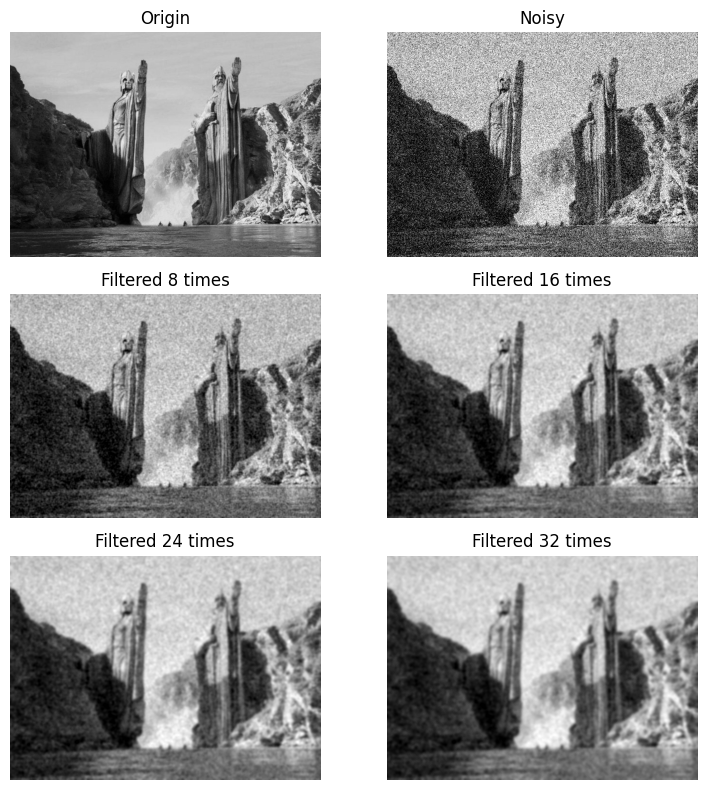

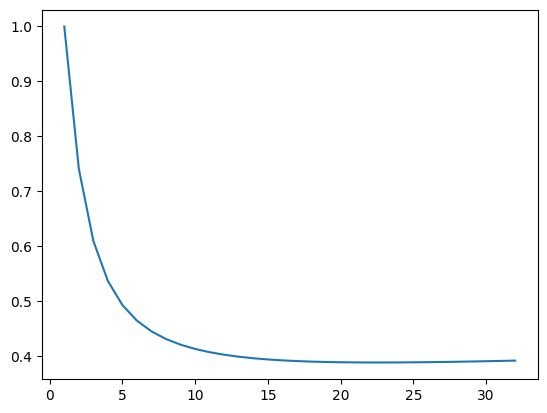

In [5]:
gauss_filtering(I_orig, I_n)

### Task 2: Heat diffusion

In [6]:
def laplace_operator_kernel():
    return np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

def heat_diffusion(origin_img, noisy_img):
    tau = 0.075
    laplace = laplace_operator_kernel()
    images = dict()
    filtered = noisy_img
    _, axes = plt.subplots(3, 2, figsize=(8, 8))
    for i in range(1, 101):
        filtered = filtered + tau * ndimage.convolve(filtered, laplace, mode='mirror')
        images[i] = filtered
            
    for i, ax in enumerate(axes.flatten()):
        img = origin_img if i == 0 else noisy_img if i == 1 else images[(i - 1) * 25]
        img = (np.clip(img*255.0, 0, 255)).astype(np.uint8)
        title = "Origin" if i == 0 else "Noisy" if i == 1 else ("Filtered " + str((i - 1) * 25) + " times")
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
        ax.set_aspect('equal') 

    plt.tight_layout() 
    plt.show()

    errors = compute_errors(origin_img, images.values())
    plt.plot(range(1, 101), errors)
    plt.show()

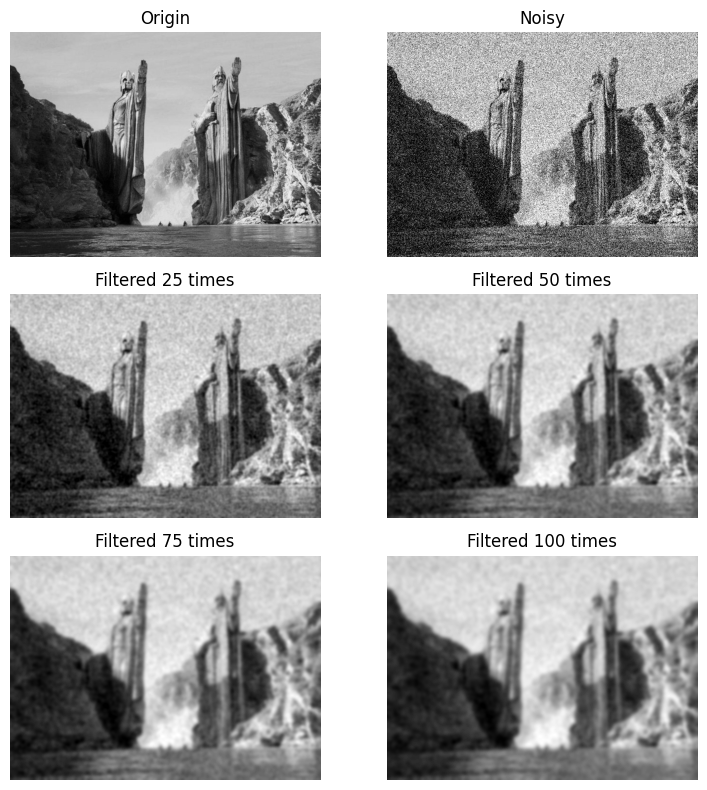

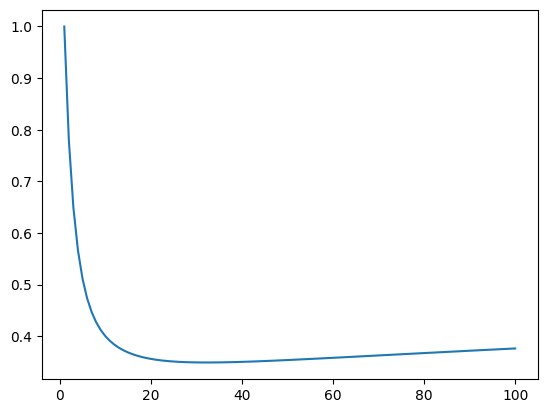

In [7]:
heat_diffusion(I_orig, I_n)

### Task 3: Variational approach

##### Energy derivation to obtain the Euler-Lagrange equation

$$
\begin{aligned}
E(I) &= \int_{\Omega} \left[ (I(x) - I_{0}(x))^2 + \lambda \|\nabla I(x)\|^2 \right] dx \\
&= \left\{ I_{u}=I(x) \right\} = \int_{\Omega} L(I_{u}, \nabla I_{u}) dx \\
\\
\\
\delta E(I_{u}; h) &= \lim_{\alpha \rightarrow 0} \dfrac{1}{\alpha} \left( E(I_{u} + \alpha h) - E(I_{u}) \right) \\
&= \lim_{\alpha \rightarrow 0} \dfrac{1}{\alpha} \int_{\Omega} L(I_{u} + \alpha h, \nabla (I_{u} + \alpha h)) - L(I_{u}, \nabla I_{u}) dx \\
&= \lim_{\alpha \rightarrow 0} \dfrac{1}{\alpha} \int_{\Omega} \left( L(I_{u}, \nabla I_{u}) + \dfrac{\partial L}{\partial I_{u}} \alpha h + \dfrac{\partial L}{\partial \nabla I_{u}} \alpha \nabla h + o(\alpha^2) \right) - L(I_{u}, \nabla I_{u}) dx \\
&= \int_{\Omega} \dfrac{\partial L}{\partial I_{u}}h + \dfrac{\partial L}{\partial \nabla I_{u}} \nabla h dx = \int_{\Omega} \left( \dfrac{\partial L}{\partial I_{u}} - \nabla\dfrac{\partial L}{\partial \nabla I_{u}} \right) h(x) dx \\
\\
&= \begin{pmatrix} \text{From the Variational Principle} \\ I_{u} \text{ is an extremum of a functional} \\
\text{if } \delta E(I_{u}; h) = 0 \text{ for all } h \end{pmatrix} = 0
\\
\\
\dfrac{\partial L}{\partial I_{u}} &= \nabla \cdot \dfrac{\partial L}{\partial \nabla I_{u}} \text{,} \qquad \qquad \qquad 
L = (I_{u} - I_{0})^{2} + \lambda \|\nabla I_{u}\|^2\\
\dfrac{\partial L}{\partial I_{u}} &= 2I_{u} - 2I_{0} \\
\dfrac{\partial L}{\partial \nabla I_{u}} &= 2\lambda \nabla I_{u} \text{,} \qquad \qquad \qquad 
\nabla \cdot \dfrac{\partial L}{\partial \nabla I_{u}} = 2\lambda \cdot \text{div}(\nabla I_{u})
\end{aligned}
\\
$$


So finally, divide both parts by 2, simple equation transformation and we get: $I_{0} = I_{u} - \lambda \cdot \text{div}(\nabla I_{u})$

##### Solve the variational problem and show the denoised image

In [8]:
def variational(noisy_img):
    _lambda = 2
    a = 1 + 4 * _lambda
    b = -_lambda
    h, w = noisy_img.shape
    Io_vect = noisy_img.flatten()
    A = lil_matrix((h*w, h*w))

    for pos in range(h*w):
        row, col = pos // w, pos % w
        A[pos, pos] = a
        if col > 0:
            A[pos, pos-1] = b
        if col < w - 1:
            A[pos, pos+1] = b
        if row < h - 1:
            A[pos, pos+w] = b
        if row > 0:
            A[pos, pos-w] = b
    
    A = csr_matrix(A)
    Iu_vect = spsolve(A, Io_vect)
    filtered = Iu_vect.reshape(h,w)

    _, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(noisy_img, cmap='gray')
    axes[0].set_title("Noisy")
    axes[0].axis('off')
    axes[1].imshow(filtered, cmap='gray')
    axes[1].set_title("Filtered")
    axes[1].axis('off')
    plt.tight_layout() 
    plt.show()

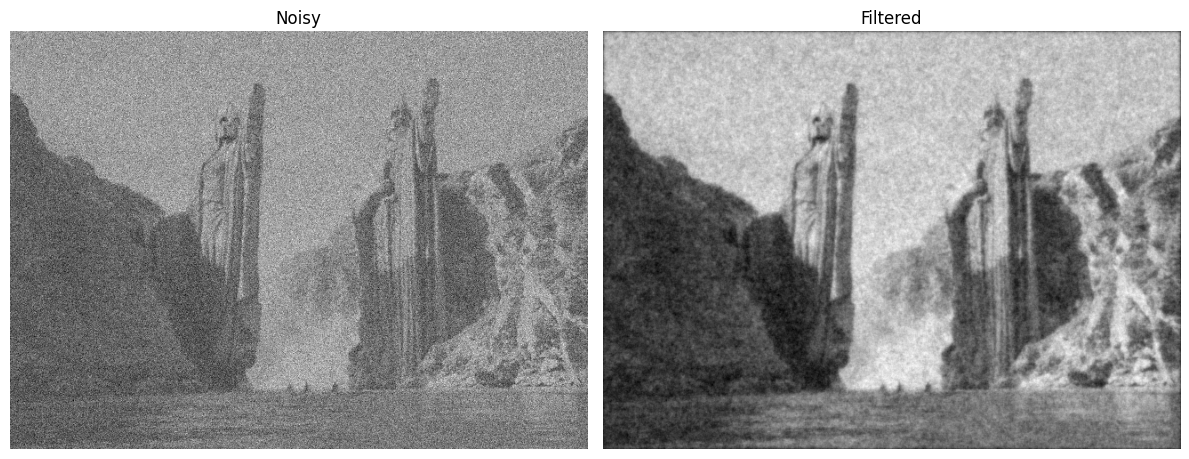

In [9]:
variational(I_n)

### Task 4: Comparison / Questions.

1. When running the gaussian convolution over and over, does the solution converge? If so, what would be the steady state? Does it depend on the boundary conditions (Neumann vs Dirichlet)?

    - Yes, as Gaussian filtering is a form of low-pass filtering it does converge to a stable state eventually, when all high-frequency components such as noise and fine details have been filtered out. The steady state will look like overly smooth image with an average gray value. In my opinion Dirichlet boundary condition may introduce slight bias toward constant value that is used for padding (towards black if 0). But this bias probably won't be very significant for the general look of the steady state.

2. If you apply heat diffusion infinitely, does it converge to a steady state? If so, what would be the steady state? Does it depend on the boundary conditions (Neumann vs Dirichlet)?

    - Yes, as well as Gaussian Blur, heat diffusion is a form of low-pass filtering, and converges to the equilibrium state that is a constant overly smooth image with the average gray value. As well as in the Gaussian blur the boundary condition will introduce a bias towards some color of the steady state.
    
3. What is the Euler Lagrange equation of an energy? What is its purpose?

    - The Euler-Lagrange equation in general represents the equation that is used to find the function that minimizes or maximizes a certain functional (like a derivative of a function, but this one is for functional - function whose input is another function). In the context of energy we are trying to find an optimal image that minizes the energy - it should be as close to the noisy image as possible while encourages the resulting image to be smooth and continuous (by minimizing the gradient or variation in the filtered image). 

4. Is the solution of the Euler-Lagrange equation globally optimal? What parameter can you modify to change the level of smoothing? Explain in your own words how it works.

    - It can be, but there is no guarantee that the solution will be globally optimal, it works in the same way as with the derivative of a function, we can find local optima of the functional instead of the global. To change the level of smoothness we can vary the lambda value. As I mentioned in the previous answer minimizing the gradient of the filtered image encourages smoothness, so if we increase lambda we will increase the priority to make the filtered image smother, and it will be less important for the image to look close to the noisy one, and vice versa. 

5. How can you describe the results? Does any of these methods give better results than the others? Explain briefly your answer.

    - The results of these approaches look quite similar, which is expected as with appropriate parameters they should compute the same image. All of these methods encourage smoothness to reduce noise, but this also removes fine details from the resulting image. Because of that all edges and boundaries of objects look not that well defined. 

6. What are the benefits and drawbacks of each methods?

    1) Gaussian filtering: it's a very simple method and idea in general, but how to receive good results is very unclear and depends on many parameters, such as kernel size, sigma value, number of iterations, boundary coditions. 

    2) Heat diffusion: has similar pros and cons to the Gaussian Blur, except that additional advantage is smaller neighborhood structure, which means that for bigger sigma it will require less memory. To extra cons can be added even slower convergence than with gaussian blur, because tau should be small for stability, but it is also not clear what value should be this tau.

    3) Energy minimization: in my opinion objective of this method is much more clear than with other methods, we directly try to find close image to the given but smother, and find perfect balance between these 2 properties. This method is also very efficient, we just need to directly solve a linear system, which can be done very fast, and there is no need to perform lots of iterations (and we don't know how many) as with other methods to achieve final result. We also don't need to specify any assumptions such as boundary conditions for example.

7. Can you explain the motivations / intuitions behind each of the methods?

    1) Gaussian filtering: the objective of this method is to reduce variations in pixel itensity by blending pixel together with thir neighbors using gaussian kernel and convolution. These variations are usually how noise presents itself, and because of this gaussian blur is used for denoising.

    2) Heat diffusion: the intuition behind this approach is similar to Gaussian Blur, because 2D Laplacian of an image highlights regions of rapid intensity change as well, and then we subtract them from the original image weighted be some small tau. The difference is in the way how the kernel for convolution is built (the image generated by applying 2D Laplacian highlights intensity changes much more than Gaussian kernel, but then it will be weighted by small tau). This methods came to computer science from physical analogy of heat transfer, so it has physical interpretation as well.

    3) Energy minimization: the intuition behind this approach is very straightforward in my opinion, we are striving to find a perfect balance between smoothness of the filtered image, and how close it is to the noisy one (this is needed so it won't look completely blurred out, which is possible with other approaches if not stopped early enough).